In [3]:
import numpy as np
import pandas as pd
import re
import pickle
import lightgbm as lgb
from sklearn.model_selection import cross_validate, StratifiedKFold
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import matplotlib.pyplot as plt
from collections import Counter
import MeCab

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'IPAGothic'

In [4]:
mecab_param = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")

In [5]:
train = pd.read_csv("../data/train_Youto_sentence_and_heading.csv")

with open("../dump/clue_words.pickle", 'br') as f:
    clue_word_by_BS = pickle.load(f)
    
clue_word_entropy = pd.read_csv("../data/clue_word_of_Sahen-setsuzoku_with_beta=0.1.csv", names=['clue_word']).clue_word.values

In [6]:
# ブートストラップ法で得た手がかり語で学習データをフィルタリング
print("train length :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train = train.loc[train.sentence.str.contains("|".join(clue_word_by_BS))].reset_index(drop=True)
print("train length (filtering) :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train length : 6671
label 1 : 1514 	label 0 : 5157
train length (filtering) : 3341
label 1 : 1045 	label 0 : 2296


In [7]:
# 文中に各手がかり語が含まれているどうかの特徴量を作成

feature_word_dict = {}

for word in np.append(clue_word_entropy, ['用途', '効果', '目的', '用い', '使わ']):
    feature_word_dict[word] = train.sentence.str.contains(fr'{word}').tolist()

In [8]:
# サブタイトル名をもとにカテゴリ変数を作成する

train = train.assign(heading_cat = np.nan)

cat1 = r'NO_SUBTITLE'
train.loc[train.heading.str.contains(cat1), 'heading_cat'] = 0

cat2 = r'|'.join(np.append(clue_word_entropy, ['用途', '効果', '目的']))
train.loc[train.heading.str.contains(cat2), 'heading_cat'] = 1

train.loc[train.heading_cat.isna(), 'heading_cat'] = 2

train.heading_cat = train.heading_cat.astype('category') 

In [ ]:
# 文中にカテゴリ名が含まれているどうか
category_list = '|'.join(pd.read_csv("../data/category_in_noun_list.csv").category.values)
is_contain_cat = train.sentence.str.contains(category_list).tolist()

In [9]:
# 文中にカテゴリ名・記事タイトル名と一致する名詞が含まれているどうか
noun_list = '|'.join(pd.read_csv("../data/noun_list_in_category_and_title.csv").noun.values)
is_noun_cat = train.sentence.str.contains(noun_list).tolist()

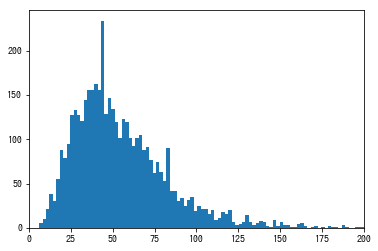

In [152]:
# 文字列長を特徴量にする

plt.xlim((0, 200))
plt.hist(train.sentence.str.len(), bins=500)
plt.show()

In [164]:
train = train.assign(length_cat = np.nan)

train.loc[train.sentence.str.len() < 25, 'length_cat'] = 0
train.loc[(train.sentence.str.len() >= 25) & (train.sentence.str.len() < 50), 'length_cat'] = 1
train.loc[(train.sentence.str.len() >= 50) & (train.sentence.str.len() < 75), 'length_cat'] = 2
train.loc[(train.sentence.str.len() >= 75) & (train.sentence.str.len() < 100), 'length_cat'] = 3
train.loc[train.sentence.str.len() >= 100, 'length_cat'] = 4

train.length_cat = train.length_cat.astype('category') 

### 最後にマッチングした手がかり語より前5単語の品詞をカテゴリ変数として特徴量を作成

In [27]:
def remove_clue_word_from_sentence(s, clue_word_list):
    return s[:list(re.finditer(r'|'.join(clue_word_list), s))[-1].start()]

def get_hinshi_list(s, prev=5):
    if len(s) is 0:
        return [np.nan] * prev
    
    node = mecab_param.parseToNode(s)
    hinshi = []
    while node:
        if len(node.surface) is 0:
            node = node.next
            continue

        hinshi.append(node.feature.split(',')[0])
        node = node.next
    
    return hinshi[::-1][:prev]

In [28]:
hinshi_df = \
pd.concat(
    [train
    , pd.DataFrame(
        train.sentence.apply(remove_clue_word_from_sentence, args=(clue_word_by_BS,)).apply(get_hinshi_list).tolist()
        , columns=[
            'prev1_hinshi_cat'
            , 'prev2_hinshi_cat'
            , 'prev3_hinshi_cat'
            , 'prev4_hinshi_cat'
            , 'prev5_hinshi_cat']
        , dtype='category'
    )]
    , axis=1
)

## 学習

In [32]:
train_X = \
pd.DataFrame(feature_word_dict).assign(
    heading_cat = train.heading_cat
    , is_noun_cat = is_noun_cat
    #, prev1_hinshi_cat = hinshi_df.prev1_hinshi_cat
    #, prev2_hinshi_cat = hinshi_df.prev2_hinshi_cat
    #, prev3_hinshi_cat = hinshi_df.prev3_hinshi_cat
    #, prev4_hinshi_cat = hinshi_df.prev4_hinshi_cat
    #, prev5_hinshi_cat = hinshi_df.prev5_hinshi_cat
)
train_y = train.label.tolist()

In [36]:
model = lgb.LGBMClassifier(is_unbalance=False)

scores = cross_validate(model, train_X, train_y, scoring=['f1', 'precision', 'recall'], cv=5)

print("f1: ", scores['test_f1'].mean())
print("precision: ", scores['test_precision'].mean())
print("recall: ", scores['test_recall'].mean())

f1:  0.6876232300899103
precision:  0.6884738894617236
recall:  0.6899521531100478


In [37]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = lgb.LGBMClassifier(
        n_estimators=500,
        **params
    )
    
    score = cross_validate(clf, train_X, train_y, scoring='f1', cv=5)['test_score'].mean()
    print("f1 {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf',  5, 25, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.03, 0.2),
    'subsample': hp.uniform('subsample', 0.5, 1.0)
}

best = fmin(fn=objective
            ,space=space
            ,algo=tpe.suggest
            ,max_evals=50
           )

f1 0.681 params {'num_leaves': 170, 'colsample_bytree': '0.632'}
f1 0.681 params {'num_leaves': 130, 'colsample_bytree': '0.622'}
f1 0.681 params {'num_leaves': 150, 'colsample_bytree': '0.548'}
f1 0.686 params {'num_leaves': 60, 'colsample_bytree': '0.794'}
f1 0.686 params {'num_leaves': 170, 'colsample_bytree': '0.747'}
f1 0.685 params {'num_leaves': 140, 'colsample_bytree': '0.865'}
f1 0.681 params {'num_leaves': 140, 'colsample_bytree': '0.502'}
f1 0.686 params {'num_leaves': 170, 'colsample_bytree': '0.764'}
f1 0.686 params {'num_leaves': 80, 'colsample_bytree': '0.780'}
f1 0.685 params {'num_leaves': 160, 'colsample_bytree': '0.891'}
f1 0.686 params {'num_leaves': 90, 'colsample_bytree': '0.771'}
f1 0.683 params {'num_leaves': 80, 'colsample_bytree': '0.637'}
f1 0.686 params {'num_leaves': 70, 'colsample_bytree': '0.803'}
f1 0.687 params {'num_leaves': 160, 'colsample_bytree': '0.715'}
f1 0.687 params {'num_leaves': 190, 'colsample_bytree': '0.668'}
f1 0.685 params {'num_leaves':

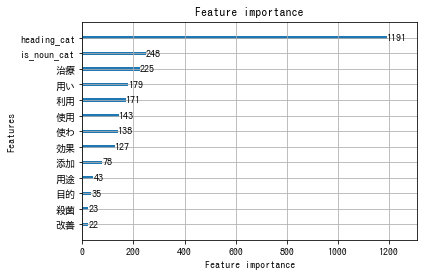

In [40]:
model.fit(train_X, train_y)
lgb.plot_importance(model)

In [41]:
predict = model.predict(train_X)

In [42]:
TP_index = np.where((predict == train_y) & (predict == 1))[0]
TN_index = np.where((predict == train_y) & (predict == 0))[0]
FP_index = np.where((predict != train_y) & (predict == 1))[0]
FN_index = np.where((predict != train_y) & (predict == 0))[0]

In [43]:
print("TP: ", len(TP_index))
print("TN: ", len(TN_index))
print("FP: ", len(FP_index))
print("FN: ", len(FN_index))

TP:  733
TN:  1994
FP:  302
FN:  312


In [44]:
print(train.loc[TP_index, 'sentence'].values)

['脂入りはんだのフラックスの主要成分である[1]ほか、ラッカー、ワニス、石鹸や樹脂酸金属塩の製造に用いられる。'
 'WHOのコメントから抜粋： “ピラゾロン系の解熱鎮痛消炎薬であるイソプロピルアンチピリンは1951年にリウマチ治療薬として発表された。'
 '皮膚や眼のアレルギー症状やアレルギー性鼻炎に用いられる。'
 'カプセル、シロップ、ドライシロップ 気管支喘息（有効率：63.6%）、アレルギー性鼻炎（64.1%）、皮膚アレルギー症状（蕁麻疹、湿疹・皮膚炎、皮膚瘙痒症）（71.9%）（添付文書の数値を集計） 点眼液 アレルギー性結膜炎（有効率：69.1%） 点鼻液 アレルギー性鼻炎（有効率：60.1%） ケトチフェンは点眼液として用いると季節性アレルギーに関する目の痒みおよび／または刺激感を和らげる。'
 '抗ヒスタミン作用の他に、ロイコトリエン阻害効果とホスホジエステラーゼ阻害効果を持つ。'
 '熱硬化性塗料、接着剤、繊維処理剤、コポリマーの改質、潤滑油添加剤のほか、共重合による樹脂改質剤、紫外線硬化樹脂用反応性希釈剤としても使用される。'
 '主に無水カフェインとして、一般消費者向けの総合感冒薬や鎮痛薬に添加されることが多いほか、臨床的に偏頭痛等に用いられる場合がある。'
 '医薬品では総合感冒薬や鎮痛薬に用いられる。' 'アンブロキシドは竜涎香の雰囲気を作り出すため、また保留剤として香水で使われる。'
 '少量 (< 0.01 ppm) が食品のフレーバーとして使われる。'
 '米国食品医薬品局は2013年11月にマントル細胞リンパ腫の治療薬としてイブルチニブを承認した後、2014年2月には慢性リンパ性白血病（CLL）について、2014年7月には染色体17p欠失CLLについて追加承認した。'
 '2015年1月にはさらに、ワルデンシュトレーム型マクログロブリン血症（英語版）への使用が承認された。'
 '日本では2014年に慢性リンパ性白血病、小リンパ球性リンパ腫、マントル細胞リンパ腫の治療薬として希少疾病用医薬品に指定され、同年11月に承認申請され、2016年3月に慢性リンパ性白血病（小リンパ球性リンパ腫を含む）について承認された。'
 'リンパ球の一つであるB細胞に由来する悪性腫瘍である瀰漫性大細胞型B細胞性リンパ腫や多発性骨髄腫の治療に使用される。